### Manipulating the training data on the fly 
In contrast to the simple book [DataAugmentation.ipynb](DataAugmentation.ipynb) where we explained how to do augmentation, we now show the real value of augmenting the training data in order to reduce overfitting by creating more training examples. This notebook runs a bit longer, it can be controlled via the following variables:

In [1]:
dataSize = 2000
verbose = False #If you don't want to print out something
epochs_no_augmentation = 200
epochs_augmentation = 200

#### Loading the data

In [2]:
#from load_mnist import load_data_2d
#X,y,PIXELS = load_data_2d('../../data/mnist.pkl.gz')
import cPickle as pickle
import gzip
with gzip.open('mnist_4000.pkl.gz', 'rb') as f:
    (X,y) = pickle.load(f)
PIXELS = len(X[0,0,0,:])
X.shape, y.shape, PIXELS

((4000, 1, 28, 28), (4000,), 28)

### Rescaling 
A small technicality: For doing the transformation the data has to be in the range [-1,1] (due to the limitation of skimage.transform library). We therefore rescale the data to the range [0,256] and dived by 256 later when we do the augmentation.

In [3]:
import numpy as np

#maxs = np.max(X[:,0,:,:],axis=(1,2))
#mins = np.min(X[:,0,:,:],axis=(1,2))
#Xs = np.zeros_like(X)
#for i in range(len(X)):
#    Xs[i,0,:,:] = (X[i,0,:,:] - maxs[i])/(maxs[i]-mins[i])
#X = Xs

Xs = (X - np.min(X)) / (np.max(X) - np.min(X))
X = Xs * 256.0    
np.min(X),np.max(X)

(0.0, 256.0)

### Defining the network
We use the standart CNN network again and do no augmentation in the first round.

In [4]:
from lasagne import layers
from lasagne import nonlinearities
from nolearn.lasagne import NeuralNet

def createNet():
   return NeuralNet(
        # Geometry of the network
        layers=[
            ('input', layers.InputLayer),
            ('conv1', layers.Conv2DLayer),
            ('pool1', layers.MaxPool2DLayer),
            ('conv2', layers.Conv2DLayer),
            ('pool2', layers.MaxPool2DLayer),
            ('hidden4', layers.DenseLayer),
            ('output', layers.DenseLayer),
            ],
        input_shape=(None, 1, PIXELS, PIXELS), #None in the first axis indicates that the batch size can be set later
        conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2), #pool_size used to be called ds in old versions of lasagne
        conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
        hidden4_num_units=500,
        output_num_units=10, output_nonlinearity=nonlinearities.softmax,

        # learning rate parameters
        update_learning_rate=0.01,
        update_momentum=0.90,
        regression=False,
        # We only train for 10 epochs
        max_epochs=10,
        verbose=1,

        # Training test-set split
        eval_size = 0.2
        )

Using gpu device 0: GRID K520


#### Fitting (no augmentation)

In [5]:
netnoAug = createNet()
netnoAug.max_epochs = epochs_no_augmentation
netnoAug.verbose = verbose
d = netnoAug.fit(X[0:dataSize,:,:,:],y[0:dataSize]);

# Neural Network with 1166086 learnable parameters

## Layer information

|   # | name    | size     |
|----:|:--------|:---------|
|   0 | input   | 1x28x28  |
|   1 | conv1   | 32x26x26 |
|   2 | pool1   | 32x13x13 |
|   3 | conv2   | 64x12x12 |
|   4 | pool2   | 64x6x6   |
|   5 | hidden4 | 500      |
|   6 | output  | 10       |

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  -----
      1       1.53637       0.78706      1.95204      0.77354  0.45s
      2       0.57104       0.38058      1.50044      0.88384  0.45s
      3       0.27632       0.33141      0.83375      0.89751  0.45s
      4       0.16645       0.28451      0.58506      0.90532  0.45s
      5       0.10429       0.26261      0.39715      0.91118  0.45s
      6       0.06875       0.26661      0.25786      0.91118  0.45s
      7       0.04346       0.26795      0.16220      0.91900  0.45s
      8       0.02662       0.26630      0.09

/usr/local/lib/python2.7/dist-packages/lasagne/init.py:86: UserWarning: The uniform initializer no longer uses Glorot et al.'s approach to determine the bounds, but defaults to the range (-0.01, 0.01) instead. Please use the new GlorotUniform initializer to get the old behavior. GlorotUniform is now the default for all layers.
  warnings.warn("The uniform initializer no longer uses Glorot et al.'s "
/usr/local/lib/python2.7/dist-packages/lasagne/layers/helper.py:69: UserWarning: get_all_layers() has been changed to return layers in topological order. The former implementation is still available as get_all_layers_old(), but will be removed before the first release of Lasagne. To ignore this warning, use `warnings.filterwarnings('ignore', '.*topo.*')`.
  warnings.warn("get_all_layers() has been changed to return layers in "


### Investigation of the training / validation loss.

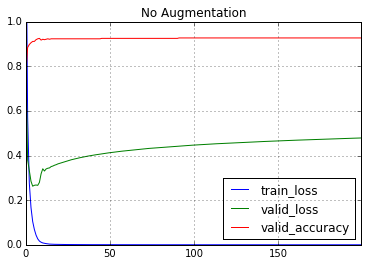

In [6]:
%matplotlib inline
import pandas as pd
dfNoAug = pd.DataFrame(netnoAug.train_history_)
dfNoAug[['train_loss','valid_loss','valid_accuracy']].plot(title='No Augmentation', ylim=(0,1))

We see a clear overfitting. The training loss drops towards 0 but after approximately 10 epochs the validation error rises again. This is a clear sign of overfitting.

This is not astonishing since we only have $1000 \cdot 80=800$ training examples for each number. We are now trying to create new training data on the fly by performing manipulations. 

## Creating manipulations of the training data
Below we define small random rotation, scalings, and translations, which keep the labels intact.

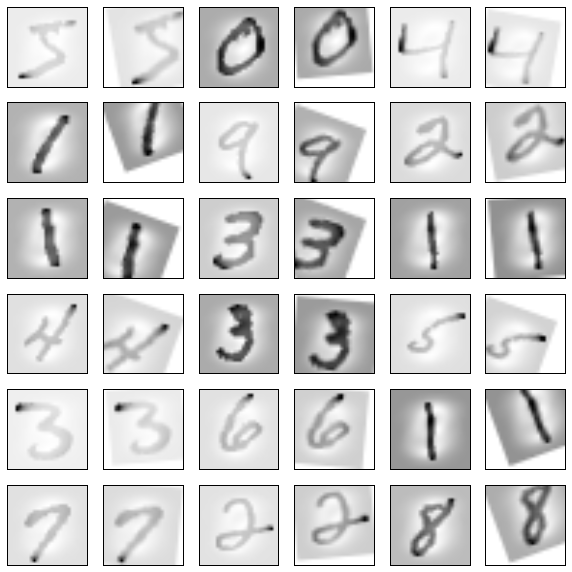

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import numpy as np
from skimage import transform as tf

rots = np.asarray((-20,-10,-5,5,10,20)) / (360 / (2.0 * np.pi))
dists = (-1,1)

def manipulateTrainingData(Xb):
    retX = np.zeros((Xb.shape[0], Xb.shape[1], Xb.shape[2], Xb.shape[3]), dtype='float32')
    for i in range(len(Xb)):
        dist = dists[np.random.randint(0, len(dists))]
        rot = rots[np.random.randint(0, len(rots))]
        scale = np.random.uniform(0.9,1.10)
        tform = tf.SimilarityTransform(rotation=rot, translation=dist, scale=scale)
        retX[i,0,:,:] = 256.0 * tf.warp(Xb[i,0,:,:]/256.0,tform) # "Float Images" are only allowed to have values between -1 and 1
    return retX


Xb = np.copy(Xs[0:100,:,:,:])
Xb = manipulateTrainingData(Xb)

fig = plt.figure(figsize=(10,10))
for i in range(18):
    a=fig.add_subplot(6,6,2*i+1,xticks=[], yticks=[])
    plt.imshow(-Xs[i,0,:,:], cmap=plt.get_cmap('gray'))
    a=fig.add_subplot(6,6,2*i+2,xticks=[], yticks=[])
    plt.imshow(-Xb[i,0,:,:], cmap=plt.get_cmap('gray'))    


#### Custom BatchIterator

The idea is to create these random transformations on the fly, each time a new minibatch is processes. We overwrite the BatchIterator again as follows:

In [9]:
from nolearn.lasagne import BatchIterator

# Our BatchIterator 
class SimpleBatchIterator(BatchIterator):

    def transform(self, Xb, yb):
        # The 'incomming' and outcomming shape is (10, 1, 28, 28)
        Xb, yb = super(SimpleBatchIterator, self).transform(Xb, yb)
        return manipulateTrainingData(Xb), yb #<--- Here we do the manipulations of the training set

# Setting the new batch iterator
net1Aug = createNet()
net1Aug.max_epochs = epochs_augmentation
net1Aug.batch_iterator_train = SimpleBatchIterator(256)
net1Aug.verbose = verbose
d = net1Aug.fit(X[0:dataSize,:,:,:],y[0:dataSize])

# Neural Network with 1166086 learnable parameters

## Layer information

|   # | name    | size     |
|----:|:--------|:---------|
|   0 | input   | 1x28x28  |
|   1 | conv1   | 32x26x26 |
|   2 | pool1   | 32x13x13 |
|   3 | conv2   | 64x12x12 |
|   4 | pool2   | 64x6x6   |
|   5 | hidden4 | 500      |
|   6 | output  | 10       |

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  -----
      1       2.30608       1.96445      1.17391      0.35434  0.74s
      2       2.01773       1.45139      1.39021      0.56610  0.73s
      3       1.81158       1.27584      1.41991      0.54657  0.72s
      4       1.73366       1.02107      1.69788      0.71207  0.72s
      5       1.47019       0.78629      1.86978      0.77549  0.72s
      6       1.45336       0.98191      1.48013      0.69449  0.72s
      7       1.21955       0.67311      1.81182      0.82627  0.72s
      8       1.02982       0.63660      1.61

### Overfitting ??
Let's have a look at the training history to see, if we do overfitting:

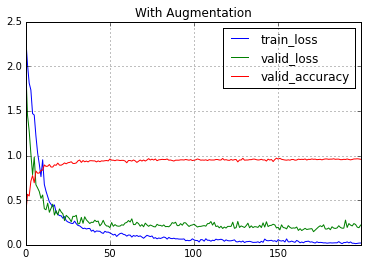

In [10]:
dfAug = pd.DataFrame(net1Aug.train_history_)
dfAug[['train_loss','valid_loss','valid_accuracy']].plot(title='With Augmentation')

We still see some overfitting, but not so severe as if we would not do augmentation. 

### Nicer Plotting with ggplot2
Just a small detour, if you have R installed you can make nice plots (using e.g. ggplot)

In [11]:
%load_ext rpy2.ipython
%Rpush dfAug
%Rpush dfNoAug

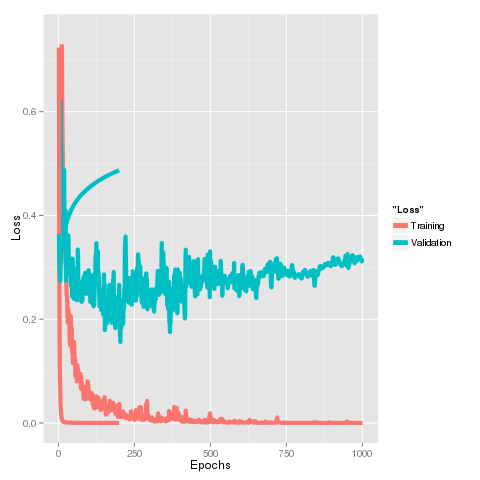

In [12]:
%%R
library(ggplot2)
ggplot() + aes(x=epoch, colour='Loss') + 
  geom_line(data=dfAug, aes(y = train_loss, colour='Training'), size=2) + 
  geom_line(data=dfAug, aes(y = valid_loss, colour='Validation'), size=2) + 
  geom_line(data=dfNoAug, aes(y = train_loss, colour='Training'), size=2) + 
  geom_line(data=dfNoAug, aes(y = valid_loss, colour='Validation'), size=2) + 
  xlab('Epochs') + ylab('Loss') +
  ylim(c(0,0.75))

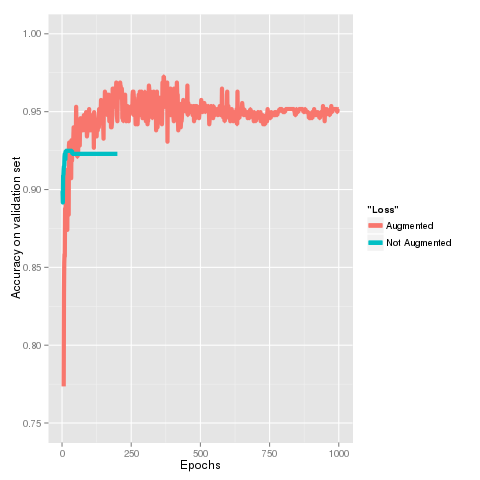

In [13]:
%%R
library(ggplot2)
ggplot() + aes(x=epoch, colour='Loss') + 
  geom_line(data=dfAug, aes(y = valid_accuracy, colour='Augmented'), size=2) + 
  geom_line(data=dfNoAug, aes(y = valid_accuracy, colour='Not Augmented'), size=2) + 
  xlab('Epochs') + ylab('Accuracy on validation set') +
  ylim(c(0.75,1))

We see that the augmentation of the training data not only mitigates overfitting but also results in a better accuracy (approx. 95% compared to 92.25%). By using all data and doing more clever augmentations the test accuracy can reach over 99.65% see [http://arxiv.org/abs/1003.0358](http://arxiv.org/abs/1003.0358)